In [1]:
import torch
import os
print(torch.cuda.is_available())

True


In [2]:
torch.cuda.set_per_process_memory_fraction(1.0, 0)

In [8]:
# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = os.path.join("..","weights","sam_vit_h_4b8939.pth")
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"

can only run the cell below once per kernal restart. If you try to create a second model (on my computer at least), it will run of out memory since it doesnt de-allocate the previous model. Should look in to how to do that because hard restart doesnt sound great long term 

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [10]:
mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=1)

In [11]:
image_path = os.path.join("..","test-data","book_shelf.jpg")

In [18]:
import cv2

image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
# image = cv2.resize(image_rgb, (224,224))

sam_result = mask_generator.generate(image_rgb)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

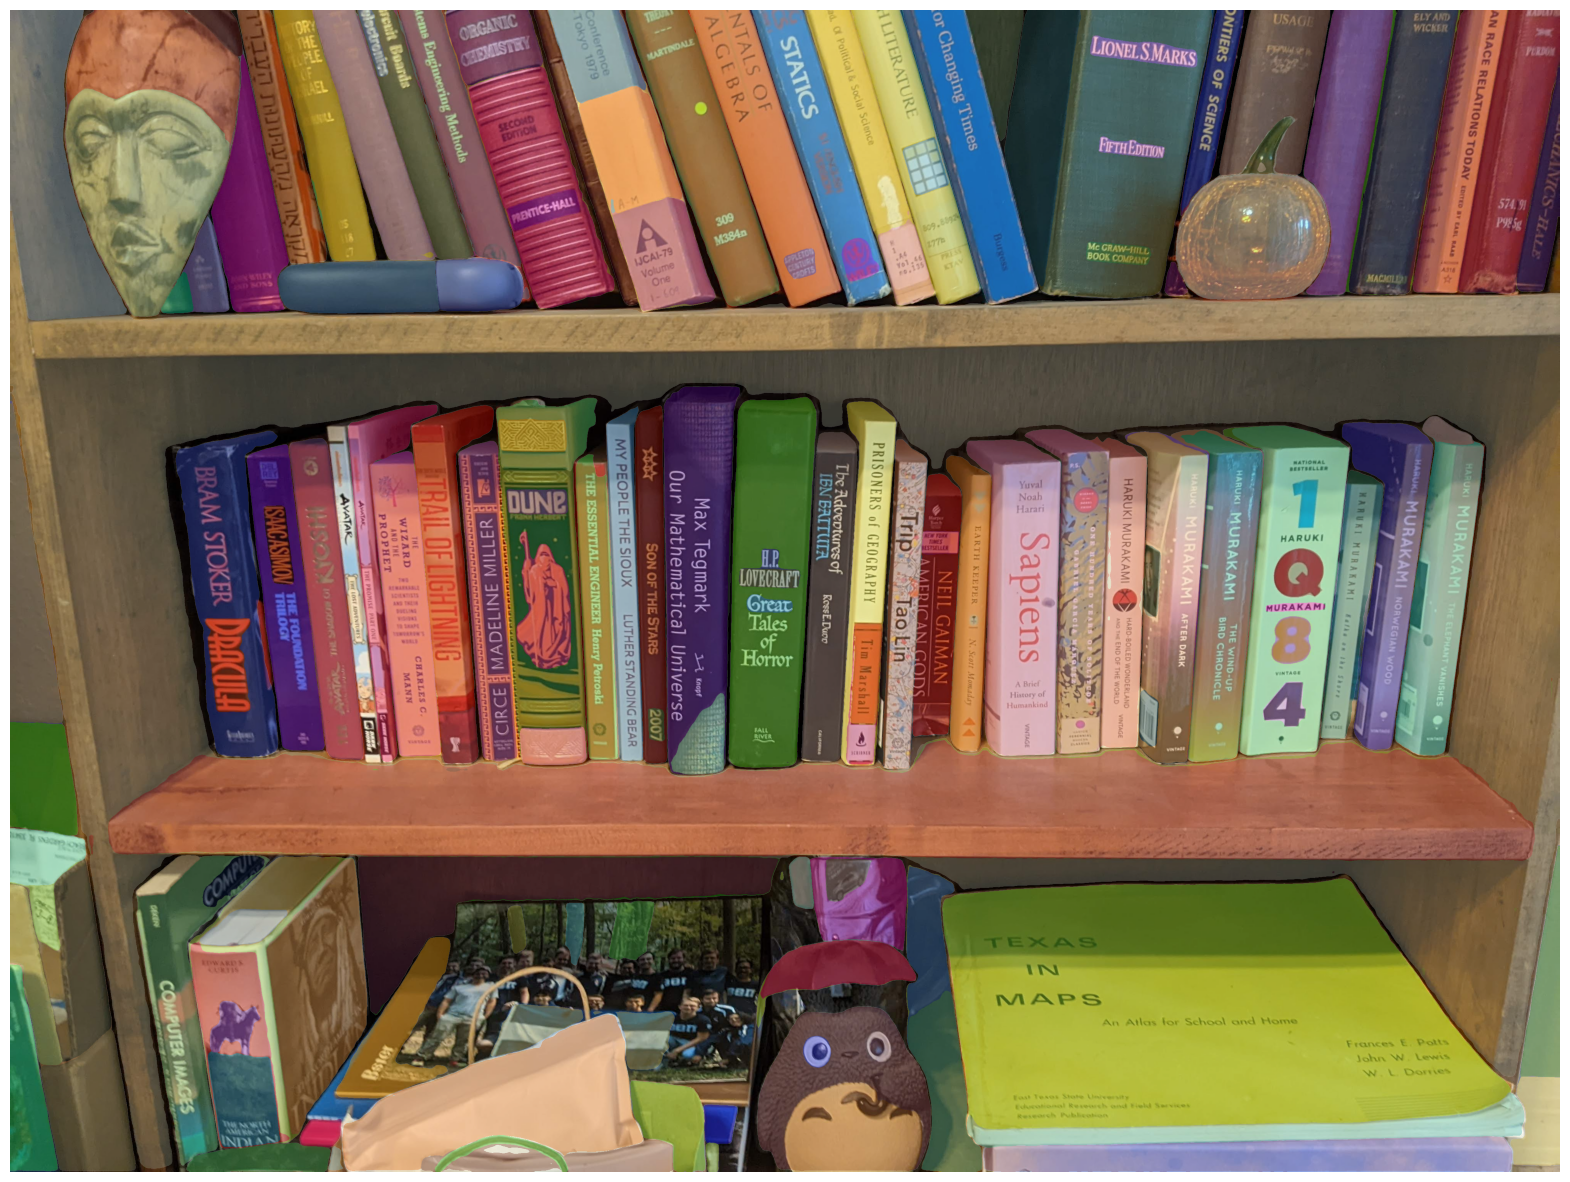

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(image_rgb)
show_anns(sam_result)
plt.axis('off')
plt.show() 

